<a href="https://colab.research.google.com/github/windaapriliyanti/Myskill/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries Implemented

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Data Loading

In [ ]:
col_names=["tweet id","entity","sentiment","tweet content"]

In [ ]:
col_names=["tweet id","entity","sentiment","tweet content"]
df = pd.read_csv("twitter_training.csv",names=col_names,header=None)
df.head()

,tweet id,entity,sentiment,tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df_val = pd.read_csv("twitter_validation.csv",names=col_names,header=None)
df_val.head()

,tweet id,entity,sentiment,tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


# Data Cleaning

**Remove null values**

In [ ]:
#Before remove
df.isnull().sum()

tweet id           0
entity             0
sentiment          0
tweet content    686
dtype: int64

In [ ]:
#After remove
df = df.dropna()
df.isnull().sum()

tweet id         0
entity           0
sentiment        0
tweet content    0
dtype: int64

**Remove duplicate values**

In [ ]:
#Before remove
df_duplicated = df.duplicated().sum()
print(f"There are {df_duplicated} duplicate values in the dataset")

There are 2340 duplicate values in the dataset


In [ ]:
#After remove
df = df.drop_duplicates()
df_remove_duplicated = df.duplicated().sum()
print(f"There are {df_remove_duplicated} duplicate values in the dataset")

There are 0 duplicate values in the dataset


**Remove outliners**

[Text(0.5, 1.0, 'Distribution of tweet content length')]

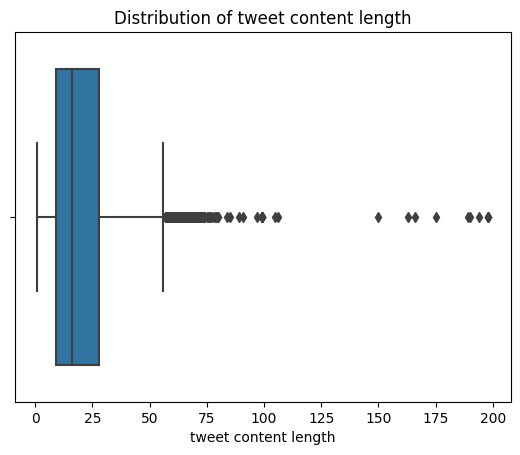

In [ ]:
#Identify outliners on tweet content length
df["tweet content length"] = df["tweet content"].map(lambda x:len(x.split(" ")))
sns.boxplot(x="tweet content length",data=df).set(title='Distribution of tweet content length')

In [ ]:
#Using Outlier Formula to remove rows

lower_quartile = np.percentile(df["tweet content length"],25) #Calculating lower_quartile
median = np.percentile(df["tweet content length"],50) #Calculating median
upper_quartile = np.percentile(df["tweet content length"],75) #Calculating upper_quartile

interquartile_range = upper_quartile - lower_quartile #Calculating interquartile_range(IQR)
lower_boundary = lower_quartile - 1.5*interquartile_range #Calculating lower_boundary
upper_boundary = upper_quartile + 1.5*interquartile_range #Calculating upper_boundary

#tweet content length smaller than lower_boundary or larger than upper_boundary will be removed
print("lower_boundary:",lower_boundary)
print("upper_boundary:",upper_boundary)

lower_boundary: -19.5
upper_boundary: 56.5


In [ ]:
#Remove outliers
removed_df = df[(df["tweet content length"]>=lower_boundary)&(df["tweet content length"]<=upper_boundary)]

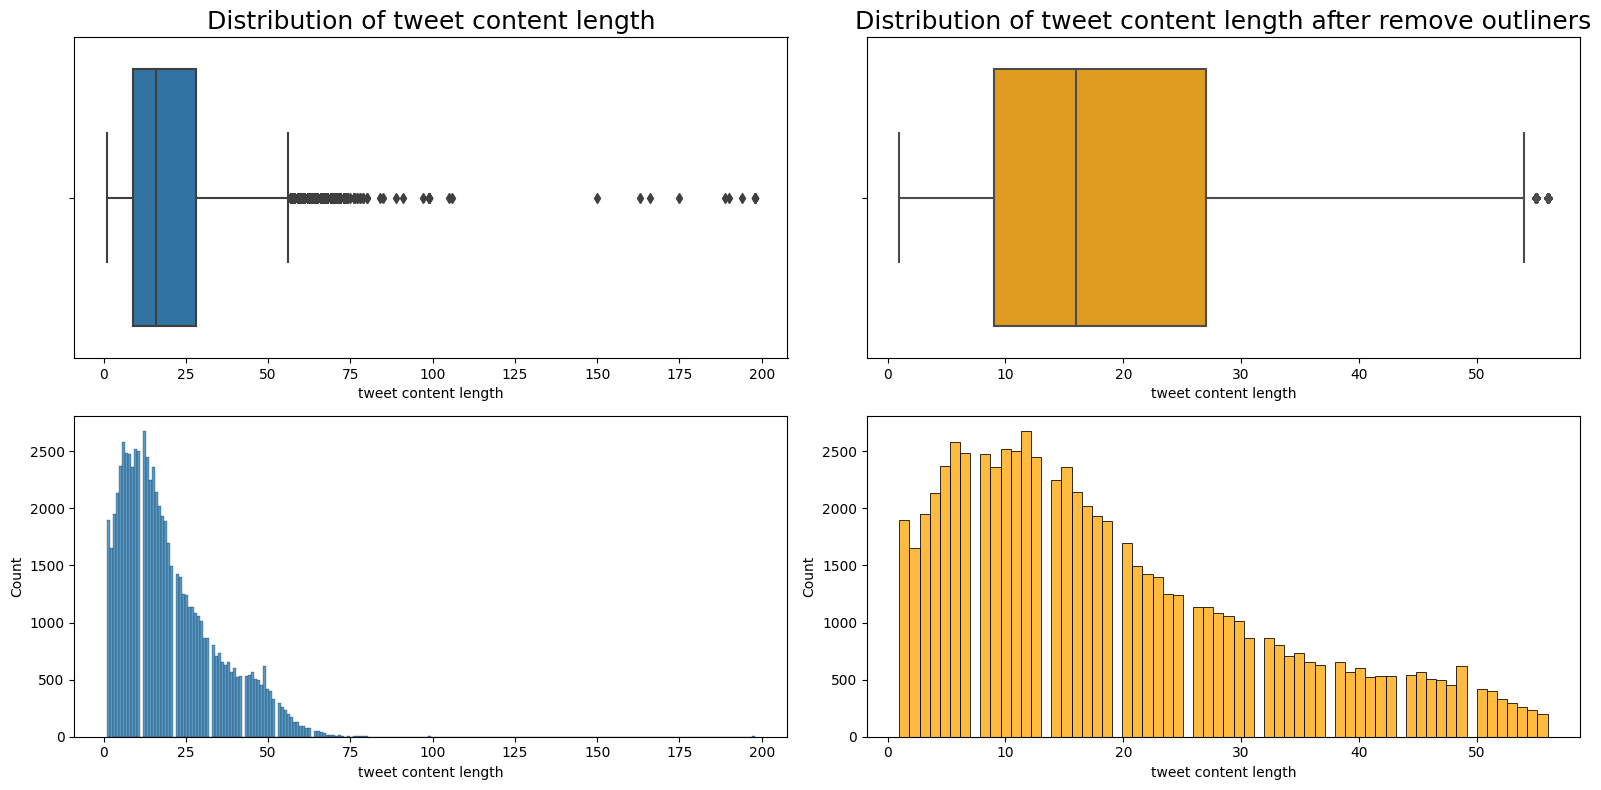

In [ ]:
#Compare the distribution of tweet content length before and after remove outliers

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))

#distribution of tweet content length
sns.boxplot(x="tweet content length",data=df,ax=ax[0,0]).set_title("Distribution of tweet content length",fontsize=18)
sns.boxplot(x="tweet content length",data=removed_df,ax=ax[0,1],color="orange").set_title("Distribution of tweet content length after remove outliners",fontsize=18)

#frequency of tweet content length
sns.histplot(x="tweet content length",data=df,ax=ax[1,0])
sns.histplot(x="tweet content length",data=removed_df,ax=ax[1,1],color="orange")

fig.tight_layout()

The tweet content length skewness is reduced after removing outliers, meaning that it has a more even distribution.

**Distribution of Labels after Data Cleaning**

<Axes: xlabel='sentiment', ylabel='count'>

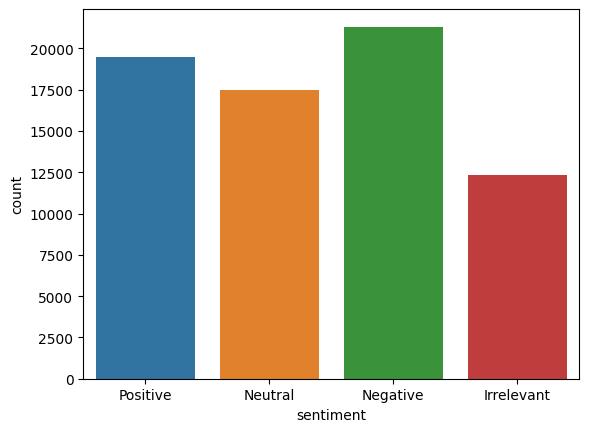

In [ ]:
sns.countplot(x="sentiment",data=removed_df)

Distribution of sentiment is balanced, therefore resampling is not required.

# Exploratory Data Analysis

**Frequency of words (wordcloud)**

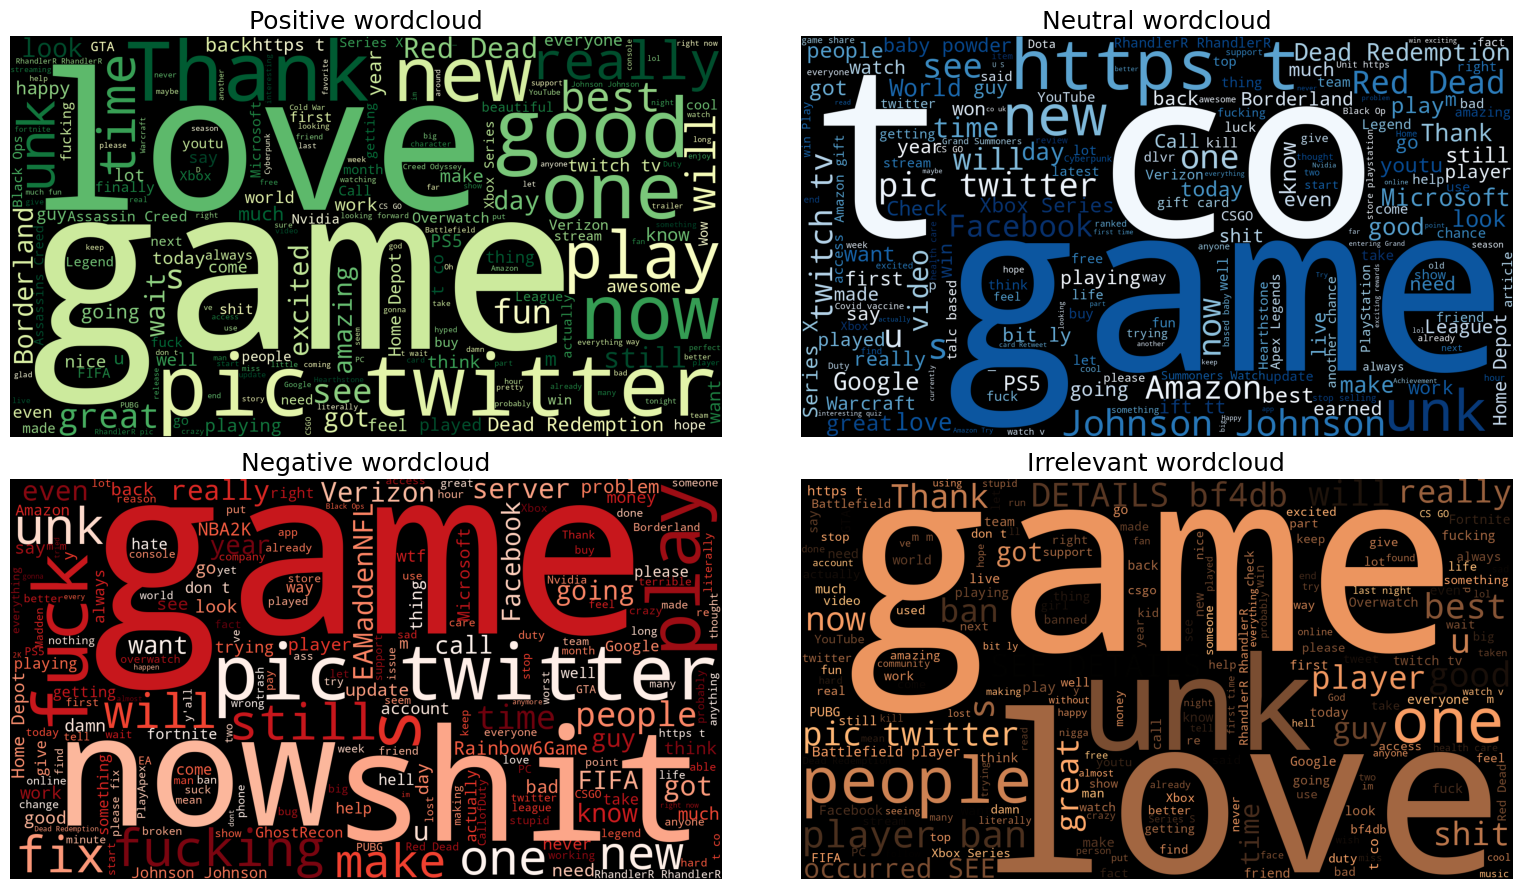

In [ ]:
sentiment_list=["Positive","Neutral","Negative","Irrelevant"]
colormap_list=["YlGn_r","Blues_r","Reds_r","copper_r"]
ax_list = [[0,0],[0,1],[1,0],[1,1]]
stopwords_set = set(STOPWORDS)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
for sentiment,(row,col),colormap in zip(sentiment_list,ax_list,colormap_list):

    #Create wordcloud for each sentiment
    text = " ".join(content for content in removed_df[removed_df["sentiment"]==sentiment]["tweet content"])
    wordcloud = WordCloud(colormap=colormap, stopwords=stopwords_set, width=1600, height=900).generate(text)

    #Plot wordcloud
    ax[row,col].imshow(wordcloud)
    ax[row,col].set_title(sentiment+" wordcloud", fontsize=18)
    ax[row,col].axis('off')

fig.tight_layout()

**Frequency of entity**

Text(0.5, 1.0, 'Frequency of entity')

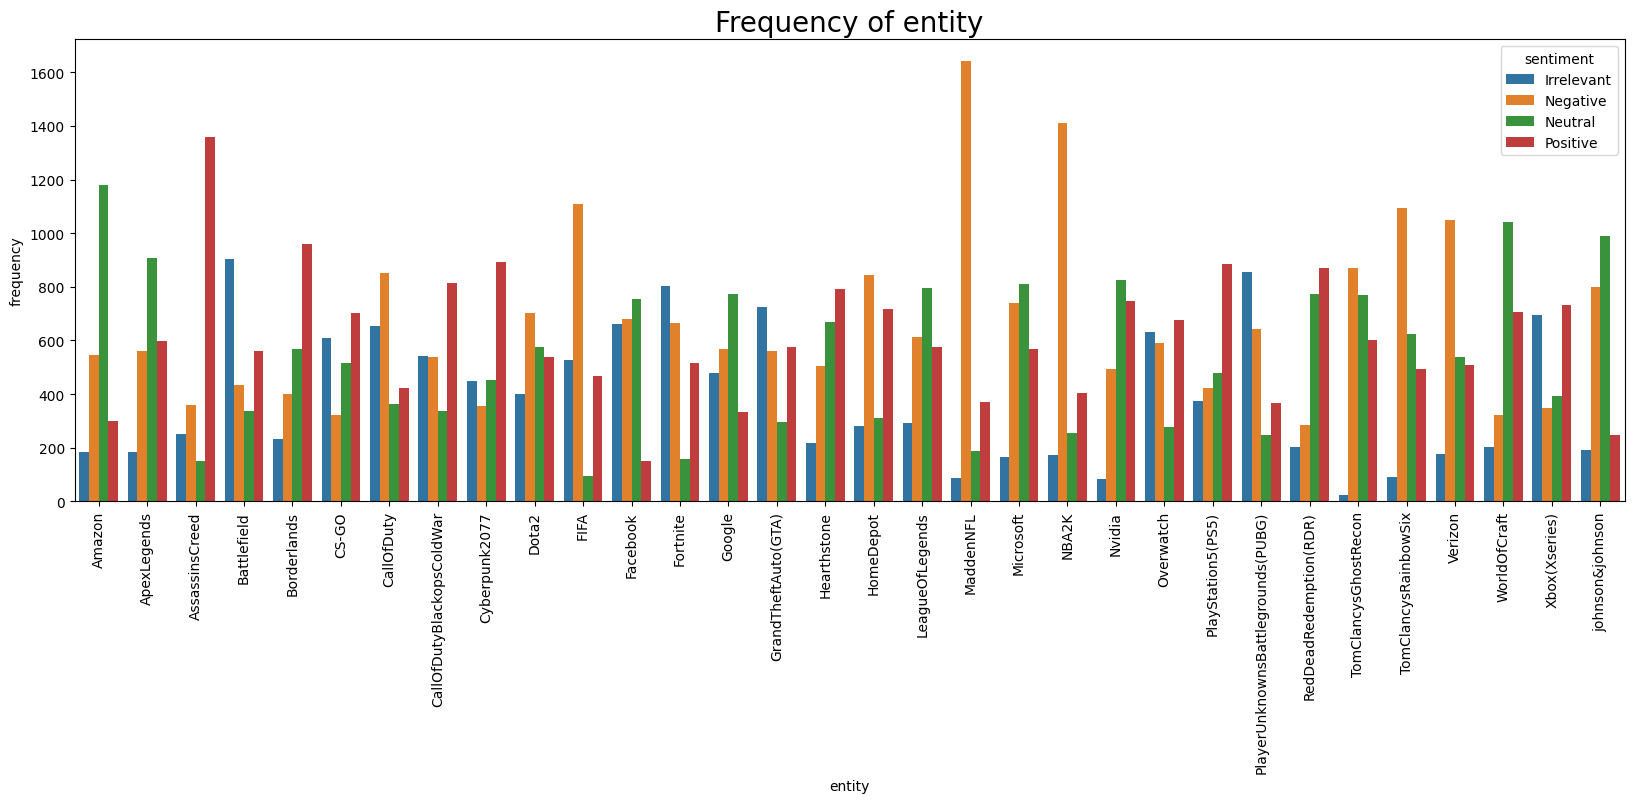

In [ ]:
entity_frequency = removed_df.groupby(["sentiment","entity"]).size().reset_index()
entity_frequency.rename(columns={0: 'frequency'}, inplace=True)

plt.figure(figsize=(20,6))
plt.xticks(rotation=90)
sns.barplot(data=entity_frequency,x="entity",y="frequency",hue="sentiment").set_title("Frequency of entity", fontsize=20)

# Data Splitting

In [ ]:
#Split the training and validation dataset into x_train, y_train, x_test and y_test
x_train = df["entity"] + " " + df["tweet content"]
y_train = df["sentiment"]
x_test = df_val["entity"] + " " + df_val["tweet content"]
y_test = df_val["sentiment"]

In [ ]:
x_train.head()

0    Borderlands im getting on borderlands and i wi...
1    Borderlands I am coming to the borders and I w...
2    Borderlands im getting on borderlands and i wi...
3    Borderlands im coming on borderlands and i wil...
4    Borderlands im getting on borderlands 2 and i ...
dtype: object

# Text Preprocessing

In [ ]:
# function turns pos_tag into wordnet_pos
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
def text_preprocessing(text):

    #tokenize
    text_tokenize = word_tokenize(text)

    #split text and entity
    entity = text_tokenize[0]
    text_content = text_tokenize[1:]

    #pos tagging
    text_pos = pos_tag(text_content)

    #remove punctuation and stopwords
    remove_words = set(list(string.punctuation) + stopwords.words('english'))
    text_remove = [(word,pos) for (word,pos) in text_pos if word not in remove_words]

    #lemmaization
    word_lem = WordNetLemmatizer()
    text_lem = [(word_lem.lemmatize(word,pos=get_wordnet_pos(pos)),pos) if get_wordnet_pos(pos) != None
                 else (word_lem.lemmatize(word),pos) for (word,pos) in text_remove]

    #combine text and entity
    text_lem.append((entity,))

    return text_lem

In [ ]:
#test text_preprocessing
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

example_text = "Overwatch Overwatch is a wonderful game, even after so many years."
print("Original sentence: ", example_text)
print("After text_preprocessing: ", text_preprocessing(example_text))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Original sentence:  Overwatch Overwatch is a wonderful game, even after so many years.
After text_preprocessing:  [('Overwatch', 'NN'), ('wonderful', 'JJ'), ('game', 'NN'), ('even', 'RB'), ('many', 'JJ'), ('year', 'NNS'), ('Overwatch',)]


In [ ]:
#Combine text_preprocessing, CountVectorizer and TfidfTransformer into pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_preprocessing)),
    ('tfidf', TfidfTransformer())
])

#Apply pipeline to x_train and x_test
x_train_processed = pipeline.fit_transform(x_train)
x_test_processed = pipeline.transform(x_test)

# Models

In [ ]:
classifier_used = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
]

In [ ]:
classifier_accuracy=[]

for classifier in classifier_used:

    fit = classifier.fit(x_train_processed, y_train)
    predict = fit.predict(x_test_processed)
    trainset_predict = fit.predict(x_train_processed)

    accuracy = accuracy_score(predict,y_test)
    trainset_accuracy = accuracy_score(trainset_predict,y_train)

    classifier_accuracy.append([classifier.__class__.__name__,accuracy,trainset_accuracy])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
classifier_result = pd.DataFrame(classifier_accuracy,columns=["classifier","accuracy","accuracy on trainset"]).sort_values(by='accuracy',ascending=False)
classifier_result

,classifier,accuracy,accuracy on trainset
1,KNeighborsClassifier,0.992,0.961832
3,RandomForestClassifier,0.977,0.986519
0,LogisticRegression,0.934,0.890365
2,DecisionTreeClassifier,0.919,0.986533


**The KNeighborsClassifier obtains the highest accuracy of 0.992.**